In [1]:
import pandas as pd
pd.__version__

'0.20.3'

In [57]:
%matplotlib inline
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
# Set plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

### String Constants

In [30]:
df_suffix = 'Df.pkl'
byTrial_suffix = 'DfByTrial.pkl'
overall_suffix = 'OverallStatsDf.pkl'
summary_suffix = 'SummaryText.txt'
date_prefix = '1017'
outdir_prefix = 'graphs/'
outdir_prefix_std_error = 'graphsWithStandardErrorBars/'

BINARY = "B"
NORMAL = "N"

BANDIT = "Bandit Sampling"
PRIOR_BTW = "Prior between"
PRIOR_BELOW = "Prior below"
PRIOR_ABOVE = "Prior above"
UNIFORM = "Uniform Sampling"
mean_names_lst = (PRIOR_BTW, PRIOR_BELOW, PRIOR_ABOVE, UNIFORM)
std_names_lst = (PRIOR_BTW + " std", PRIOR_BELOW + " std", PRIOR_ABOVE + " std", UNIFORM + " std")

bb_prefix = "bb"
bb_infix = "BB"
bu_prefix = "bbUniform"
bu_infix = "BU"
bb_prior_below_prefix = "bbHighArms"
bb_prior_above_prefix = "bbLowArms"
b_prefix_lst = (bb_prefix, bb_prior_below_prefix, bb_prior_above_prefix, bu_prefix)
b_infix_lst = (bb_infix, bb_infix, bb_infix, bu_infix)

ng_prefix = "ng"
ng_infix = "NG"
nu_prefix = "ngUniform"
nu_infix = "NU"
ng_prior_below_prefix = "ngHighArms"
ng_prior_above_prefix = "ngLowArms"
n_prefix_lst = (ng_prefix, ng_prior_below_prefix, ng_prior_above_prefix, nu_prefix)
n_infix_lst = (ng_infix, ng_infix, ng_infix, nu_infix)

# (Optimal, Prior Btw, Prior below, Prior above, Uniform)
colors = ('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99')
# (Optimal, Prior Btw, Prior Btw Regression, Uniform, Uniform Regression)
colors_line = ('#a6cee3','#1f78b4','#fc8d62','#fb9a99','#018571')

### Simulation Settings

In [4]:
effectSizeB = (0.1, 0.3, 0.5)
effectSizeN = (0.2, 0.5, 0.8)

In [5]:
effectSize_label = ("Small", "Medium", "Large")

# Average Reward Gain per Step

In [6]:
# Acutal rewards
bb_01_arms = (0.55, 0.45)
bb_03_arms = (0.65, 0.35)
bb_05_arms = (0.75, 0.25)

ng_prior_btw = (0.5, -0.5)
ng_prior_below = (1.0, 0.5)
ng_prior_above = (-0.5, -1.0)
ng_uniform = (0.5, -0.5)
ng_reward_dict = {PRIOR_BTW:ng_prior_btw, PRIOR_BELOW:ng_prior_below, PRIOR_ABOVE:ng_prior_above, UNIFORM:ng_uniform}

In [7]:
def scale_normal_rewards(x, good_arm, bad_arm):
    return ((x - (bad_arm)) / (good_arm - (bad_arm)))

In [58]:
def get_avg_col_per_num_steps_dfs(effect_size, reward_type, col, stdError=False):
    df_lst = []
    effect_size = str(effect_size)
    if reward_type == BINARY:
        prefix_lst = b_prefix_lst
        infix_lst = b_infix_lst
    elif reward_type == NORMAL:
        prefix_lst = n_prefix_lst
        infix_lst = n_infix_lst
    
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+df_suffix)
        df_lst.append(df)
        
    avg_lst = []
    std_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['num_steps', col]].groupby('num_steps')
        
        avg = gp.mean().reset_index().rename(columns={col: mean_names_lst[i]})
        avg_lst.append(avg)
        std = gp.std().reset_index().rename(columns={col: std_names_lst[i]})
        if (stdError):
            count = gp.size().reset_index(name='counts')
            std[std_names_lst[i]] = std[std_names_lst[i]] / np.sqrt(count['counts'])
            
        std_lst.append(std)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['num_steps'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['num_steps'])
    for i in range(len(std_lst)):
        result = pd.merge(result, std_lst[i], how='outer', on=['num_steps'])
        
    result = result.reset_index(drop=True).set_index('num_steps')

    return result

In [71]:
def get_avg_col_per_step_dfs(effect_size, reward_type, col, stdError=False):
    avg_total_rewards = get_avg_col_per_num_steps_dfs(effect_size, reward_type, col, stdError)
    for column in avg_total_rewards.columns:
        # Update mean and std
        avg_total_rewards[column] = avg_total_rewards[column] / avg_total_rewards.index

        # Apply scaling if normal rewards
        if col == "total_reward" and reward_type == NORMAL:
            if "std" not in column:
                # scale avg
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(scale_normal_rewards, args=(max(ng_reward_dict[column]), min(ng_reward_dict[column])))
            else: 
                # scale std
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(lambda x: x / (max(ng_reward_dict[column[:-4]]) - min(ng_reward_dict[column[:-4]])))

    return avg_total_rewards

### Get Better arm (2 arms)

In [72]:
import ast
def get_better_arm(effect_size, reward_type):
    effect_size = str(effect_size)
    if reward_type == BINARY:
        summary = open("bb"+effect_size+"BB"+effect_size+summary_suffix)
    elif reward_type == NORMAL:
        return 1

    for line in summary:
        if line.startswith("Arm stats:"):
            arms = line.split(':')[1].strip()
            return max(ast.literal_eval(arms)[:2])

## Line Plot

In [73]:
def subplot_line(df, effect_size, rewards_type, ax, setLegend, title, legend_anchor=(1, 1.65),\
                ylabel="", hline_value=None, hline_label=None, setLinearRegression=True, color=None):
    
    legend = []
    
    i = 0
    if hline_value!=None:
        if color == None:
            ax.axhline(hline_value, linestyle='dashed', linewidth=2)
        else:
            ax.axhline(hline_value, linestyle='dashed', linewidth=2, color=color[i])
            i += 1
        legend.append(hline_label)

    for col in df.columns.values:       
        x = df.index.values.reshape(len(df.index.values), 1)
        y = df[col].values
        
        if color == None:
            plt.plot(x, y)
        else:
            plt.plot(x, y, color=color[i])
            i+=1
       
        legend.append(col)
        if setLinearRegression:
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            
            if color == None:
                plt.plot(x, regr.predict(x), linewidth=2)
            else:
                plt.plot(x, regr.predict(x), linewidth=2, color=color[i])
                i += 1

            legend.append(col+" Regression")
    plt.xlabel("Step")
    ax.set_ylabel(ylabel)

    plt.title(title)

    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)

# Average Reward Gain at each Step

In [74]:
def get_avg_col_per_trial_dfsByTrial(es, reward_type, col, includeBelowAbove):
    df_lst = []
    effect_size = str(es)
    if reward_type == BINARY:
        prefix_lst = b_prefix_lst
        infix_lst = b_infix_lst
    elif reward_type == NORMAL:
        prefix_lst = n_prefix_lst
        infix_lst = n_infix_lst
    
    columns = list(mean_names_lst)
    if not includeBelowAbove:
        prefix_lst = [prefix_lst[0], prefix_lst[-1]]
        infix_lst = [infix_lst[0], infix_lst[-1]]
        columns = [columns[0], columns[-1]]
    
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+byTrial_suffix)
        df_lst.append(df)
        
    avg_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['trial', col]].groupby('trial')
        
        avg = gp.mean().reset_index().rename(columns={col: columns[i]})

        for j in range(len(avg['trial'])-1):
            avg.loc[j,columns[i]] = avg.loc[j+1,columns[i]] - avg.loc[j,columns[i]]
            
        if col == "total_reward" and reward_type == NORMAL:
            avg[columns[i]] = avg[columns[i]].\
            apply(scale_normal_rewards, \
                  args=(max(ng_reward_dict[columns[i]]), min(ng_reward_dict[columns[i]])))

        avg_lst.append(avg)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['trial'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['trial'])
   
    result = result.reset_index(drop=True).set_index('trial')
    
    return result.iloc[:-1]

In [88]:
def plot_avg_reward_gain_at_m(reward_type, legend_anchor=(1, 1.35), stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
    for i in range(len(effectSize)):
        es = effectSize[i]
        df_m = get_avg_col_per_step_dfs(es, reward_type, "total_reward", stdError=stdError).iloc[1:2]
        df_m["effect_size"] = es
        df_m["Optimal Reward"] = get_better_arm(effectSize[i], reward_type)
        df_m["or_std"] = pd.Series()

        df = pd.concat([df, df_m])
    df = df.reset_index().set_index('effect_size')
    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    ax = m.plot.bar(yerr=std, rot=0, color=colors)

    ax.set_xlabel('')
    xticks = []
    for i in range(len(df.index.values)):
        xticks.append("Effect size="+str(df.index.values[i])+",\n num_steps="+str(df['num_steps'].values[i]))
    ax.set_xticklabels(xticks)
    ax.set_ylabel("Rewards")
    
    ax.legend(ncol=5, bbox_to_anchor=legend_anchor)

    if reward_type == BINARY:
        ax.set_title("Average Reward Gain per Step in m Steps (Binary Reward)")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward Gain per Step in m Steps (Scaled, Normal Reward)")
    return ax

### Binary Rewards

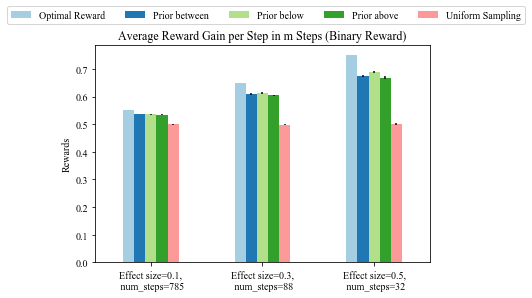

In [89]:
ax = plot_avg_reward_gain_at_m(BINARY, legend_anchor=(1.3, 1.2), stdError=True)

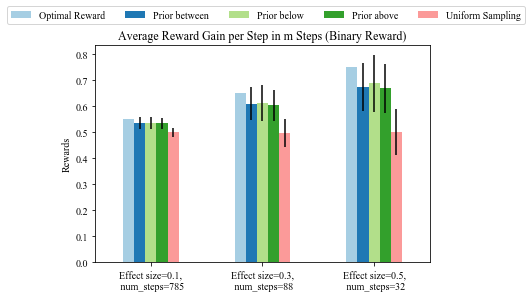

In [90]:
ax = plot_avg_reward_gain_at_m(BINARY, legend_anchor=(1.3, 1.2), stdError=False)

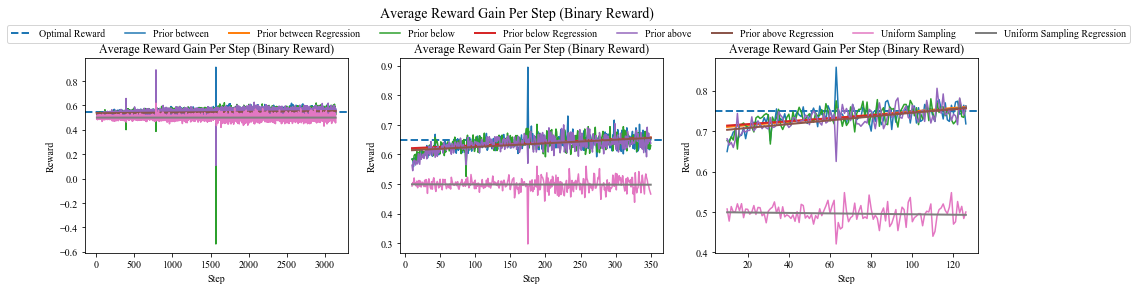

In [15]:
figure = plt.figure(figsize = (16, 4))
setLegend = True

# Plot subgraphs
axes = []
for i in range(len(effectSizeB)):
    ax = figure.add_subplot(1, len(effectSizeB), i + 1)
    axes.append(ax)

    avg_rewards_per_trial_binary = get_avg_col_per_trial_dfsByTrial(effectSizeB[i], BINARY, "total_reward", True)
    subplot_line(avg_rewards_per_trial_binary, effectSizeB[i], "Binary", ax, setLegend, "Average Reward Gain Per Step (Binary Reward)", \
                ylabel="Reward", legend_anchor=(4, 1.2), hline_value=get_better_arm(effectSizeB[i], BINARY), hline_label="Optimal Reward")
    setLegend = False

# Set super title for all subgraphs
figure.suptitle("Average Reward Gain Per Step (Binary Reward)",  fontsize=14)
plt.subplots_adjust(top=0.8)

### Normal Rewards

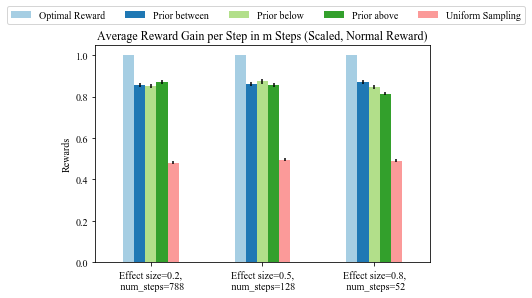

In [79]:
ax = plot_avg_reward_gain_at_m(NORMAL, legend_anchor=(1.3, 1.2), stdError=True)

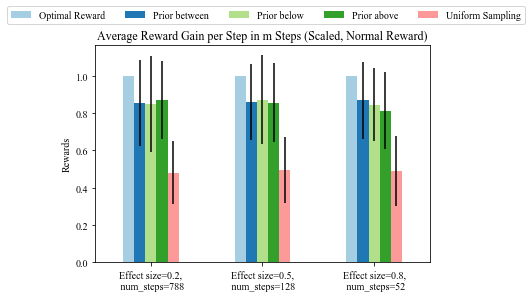

In [80]:
ax = plot_avg_reward_gain_at_m(NORMAL, legend_anchor=(1.3, 1.2), stdError=False)

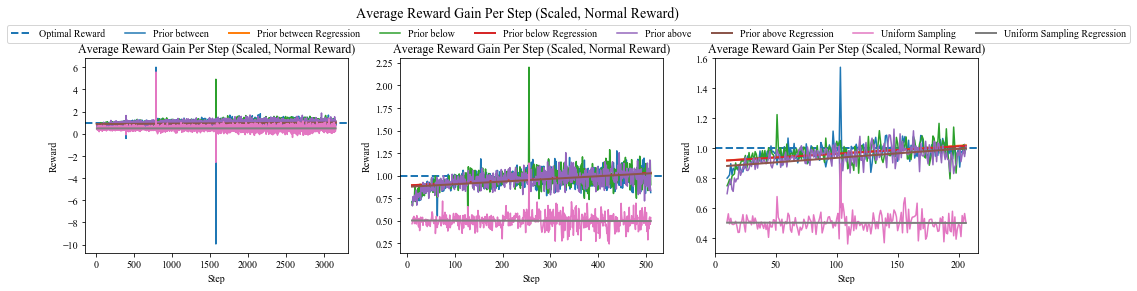

In [17]:
figure = plt.figure(figsize = (16, 4))
setLegend = True

# Plot subgraphs
axes = []
for i in range(len(effectSizeN)):
    ax = figure.add_subplot(1, len(effectSizeN), i + 1)
    axes.append(ax)

    avg_rewards_per_trial_normal = get_avg_col_per_trial_dfsByTrial(effectSizeN[i], NORMAL, "total_reward", True)
    subplot_line(avg_rewards_per_trial_normal, effectSizeN[i], "Normal", ax, setLegend, "Average Reward Gain Per Step (Scaled, Normal Reward)", \
                ylabel="Reward", legend_anchor=(4, 1.2), hline_value=get_better_arm(effectSizeN[i], NORMAL), hline_label="Optimal Reward")
    setLegend = False

# Set super title for all subgraphs
figure.suptitle("Average Reward Gain Per Step (Scaled, Normal Reward)",  fontsize=14)
plt.subplots_adjust(top=0.8)

### Combine Plots

In [81]:
def plot_avg_reward_gain_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55), stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
    for i in range(len(effectSize)):
        es = effectSize[i]
        df_m = get_avg_col_per_step_dfs(es, reward_type, "total_reward", stdError).iloc[1:2]
        df_m["effect_size"] = es
        df_m["Optimal Reward"] = get_better_arm(effectSize[i], reward_type)
        df_m["or_std"] = pd.Series()

        df = pd.concat([df, df_m])
    df = df.reset_index().set_index('effect_size')
    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors)

    ax.set_xlabel('Effect Size')
    xticks = list(effectSize_label)
    ax.set_xticklabels(xticks)
    ax.set_ylabel(ylabel)

    if hasLegend:
        ax.legend(ncol=5, bbox_to_anchor=legend_anchor)
    else:
        ax.legend_.remove()

    if reward_type == BINARY:
        ax.set_title("Average Reward By Effect Size\n (Binary Reward)")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward By Effect Size\n (Scaled, Normal Reward)")
    return ax

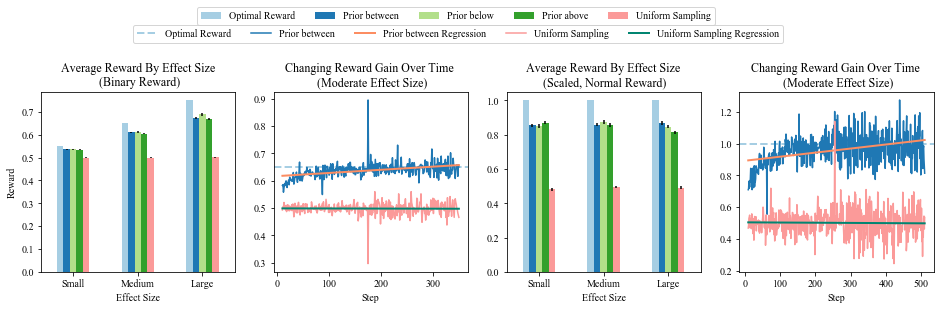

In [84]:
figure = plt.figure(figsize = (16, 4))
stdError = True
# Bar for Binary Reward 
ax = figure.add_subplot(1, 4, 1)
plot_avg_reward_gain_at_m(BINARY, ax, ylabel="Reward", legend_anchor=(3.5, 1.5), stdError=stdError)

# Line for Binary Reward 
mid_es_B = effectSizeB[len(effectSizeB) // 2]
ax = figure.add_subplot(1, 4, 2)
avg_rewards_per_trial_binary = get_avg_col_per_trial_dfsByTrial(mid_es_B, BINARY, "total_reward", False)
subplot_line(avg_rewards_per_trial_binary, mid_es_B, "Binary", ax, False, "Changing Reward Gain Over Time \n (Moderate Effect Size)", \
            hline_value=get_better_arm(mid_es_B, BINARY), hline_label="Optimal Reward", color=colors_line)

# Bar for Normal Reward 
ax = figure.add_subplot(1, 4, 3)
plot_avg_reward_gain_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)

# Line for Normal Reward 
mid_es_N = effectSizeN[len(effectSizeN) // 2]
ax = figure.add_subplot(1, 4, 4)
avg_rewards_per_trial_normal = get_avg_col_per_trial_dfsByTrial(mid_es_N, NORMAL, "total_reward", False)
subplot_line(avg_rewards_per_trial_normal, mid_es_N, "Normal", ax, True, title="Changing Reward Gain Over Time \n (Moderate Effect Size)", \
            legend_anchor=(0.25, 1.4), hline_value=get_better_arm(mid_es_N, NORMAL), hline_label="Optimal Reward", color=colors_line)

# Set super title for all subgraphs
plt.subplots_adjust(top=0.75)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'AvgRewardGainPerStep.pdf', bbox_inches='tight')

# Power

In [20]:
def get_power_per_trial_dfs(effect_size, reward_type):
    effect_size = str(effect_size)
    if reward_type == BINARY:
        df_bandit = pd.read_pickle(bb_prefix+effect_size+bb_infix+effect_size+byTrial_suffix)
        df_uniform = pd.read_pickle(bu_prefix+effect_size+bu_infix+effect_size+byTrial_suffix)
    elif reward_type == NORMAL:
        df_bandit = pd.read_pickle(ng_prefix+effect_size+ng_infix+effect_size+byTrial_suffix)
        df_uniform = pd.read_pickle(nu_prefix+effect_size+nu_infix+effect_size+byTrial_suffix)
        
    # Bandit sampling
    bandit_ppt = df_bandit[['trial','power']]
    # Uniform sampling
    uniform_ppt = df_uniform[['trial','power']]

    power_per_trial = pd.merge(bandit_ppt, uniform_ppt, how='outer', on=['trial'])\
        .set_index('trial')

    return power_per_trial

### Binary Reward

In [21]:
def get_power_by_steps(dfs_by_trial, columns, alpha = 0.05):
    '''
    df_by_trial is a data frame with information about each run,
    as calculated by calculate_by_trial_statistics_from_sims.
    This function returns the continuous evaluation of power at every step until 4m steps,
    and the power snapshot at step 0.5m, m, 2m and 4m for all effect sizes.
    Power is calculated as what proportion of the p-values were below alpha at that point.
    '''
    unique_sample_sizes = dfs_by_trial[0].num_steps.unique()

    power_df = pd.DataFrame(columns=columns)
    power_all_steps = []
    for i in range(len(unique_sample_sizes)):
        cur_n = unique_sample_sizes[i]
        power_df.loc[i,columns[0]] = cur_n
        # Add bandit and uniform sampling lines 
        j = 1
        for df in dfs_by_trial:
            cur_df = df[df['num_steps'] == cur_n]
            statistic_list = []
            for trial in range(10, cur_n):
                avg_stat = np.sum(cur_df[cur_df['trial'] == trial]['pvalue'] < alpha) \
                            / len(cur_df[cur_df['trial'] == trial])
                statistic_list.append(avg_stat)
            
            if cur_n == unique_sample_sizes[-1]:
                power_all_steps.append(statistic_list[:])
            
            power_df.iloc[i, j] = statistic_list[-1]
            j+=1
    return power_all_steps, power_df

In [22]:
def plot_power_bar(df, x_col, y_col, effect_size, ax, setLegend, title, legend_anchor=(0.7, 1.5), ylabel="", \
                   hline_value=None, hline_label=None, color=colors):
    x = df[x_col]
    y = df[y_col]

    y.plot.bar(ax=ax, rot=0, color=color[1:])
    plt.xlabel("Step, m="+str(x.iloc[1, 0]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    
    legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

In [23]:
binary_power = []
binary_power_mid_es = []
for i in range(len(effectSizeB)):
    effect_size = str(effectSizeB[i])
    df_lst = []
    prefix_lst = b_prefix_lst
    infix_lst = b_infix_lst
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+byTrial_suffix)
        df_lst.append(df)
        
    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"] + list(mean_names_lst))
    binary_power.append(power_df)
    if effect_size == str(effectSizeB[len(effectSizeB) // 2]):
        binary_power_mid_es = power_all_steps

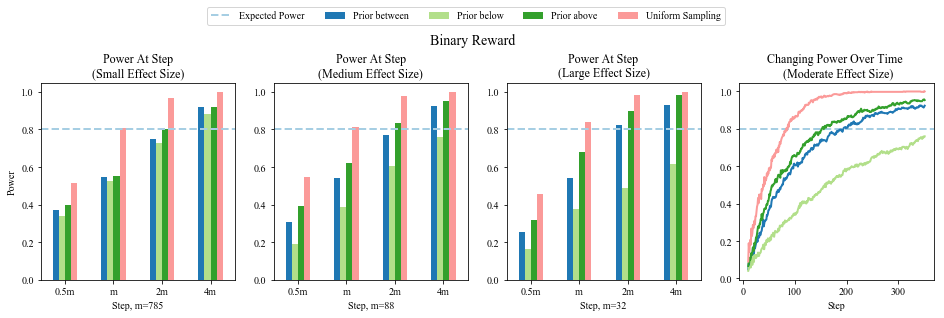

In [24]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
# Bar graph for power at step m
for i in range(len(effectSizeB)):
    ax = figure.add_subplot(1, len(effectSizeB) + 1, i + 1)

    avg_power_binary = binary_power[i]
    plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), effectSizeB[i], ax, setLegend, \
                   "Power At Step\n("+effectSize_label[i]+" Effect Size)",\
                   legend_anchor=(3.55, 1.41), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
    setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(effectSizeB) + 1, i + 2)
ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in binary_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Step')
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepBinary.pdf', bbox_inches='tight')

### Normal Reward

In [25]:
normal_power = []
normal_power_mid_es = []
for i in range(len(effectSizeN)):
    effect_size = str(effectSizeN[i])
    df_lst = []
    prefix_lst = n_prefix_lst
    infix_lst = n_infix_lst
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+byTrial_suffix)
        df_lst.append(df)
        
    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"]+list(mean_names_lst))
    normal_power.append(power_df)
    if effect_size == str(effectSizeN[len(effectSizeN) // 2]):
        normal_power_mid_es = power_all_steps

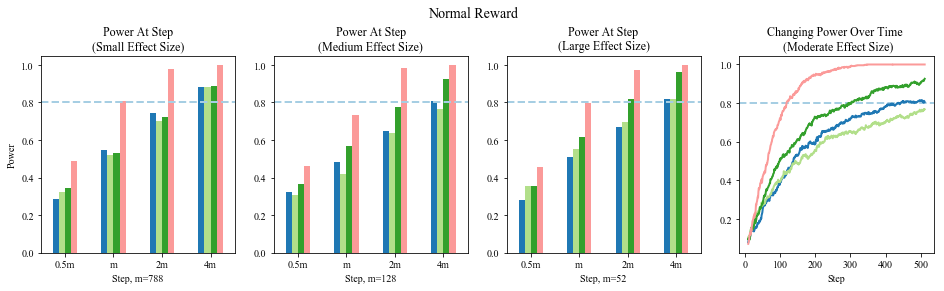

In [26]:
figure = plt.figure(figsize = (16, 4))
setLegend = False
# Bar graph for power at step m
for i in range(len(effectSizeN)):
    ax = figure.add_subplot(1, len(effectSizeN) + 1, i + 1)
    if i == 0:
        ax.set_ylabel("Power")
    avg_power_normal = normal_power[i]
    plot_power_bar(avg_power_normal, ["num_steps"], list(mean_names_lst), effectSizeN[i], ax, setLegend, \
                   "Power At Step\n("+effectSize_label[i]+" Effect Size)", \
                   legend_anchor=(0.6, 1.65), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
    setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(effectSizeN) + 1, i + 2)
ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in normal_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Step')
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

figure.suptitle("Normal Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepNormal.pdf', bbox_inches='tight')

# Average Measured Effect Size

In [27]:
def subplot_avg(df, effect_size, ax, setLegend, title, \
                ylabel="", hline_value=None, hline_label=None, setErrorBar=True, color=colors):
    means = df[list(mean_names_lst)]
    stds = df[list(std_names_lst)]
    stds.columns = list(mean_names_lst)
    
    if setErrorBar:
        means.plot.bar(ax=ax, yerr=stds, rot=0, color=color[1:])
    else:
        means.plot.bar(ax=ax, rot=0, color=color[1:])

    plt.xlabel("Step, m="+str(df.index[1]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    
    legend = list(mean_names_lst)
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=(2.7, 1.35))
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

### Binary Reward

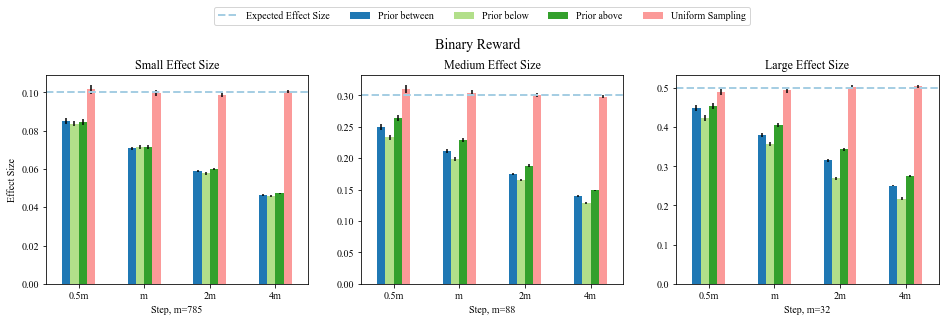

In [85]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
stdError = True

# Plot subgraphs
for i in range(len(effectSizeB)):
    ax = figure.add_subplot(1, len(effectSizeB), i + 1)
    avg_act_es_binary = get_avg_col_per_num_steps_dfs(effectSizeB[i], BINARY, "actual_es", stdError=stdError)
    subplot_avg(avg_act_es_binary, effectSizeB[i], ax, setLegend, effectSize_label[i]+" Effect Size", \
                ylabel="Effect Size", hline_value=effectSizeB[i], hline_label="Expected Effect Size", setErrorBar=True)
    setLegend = False
    
# Set super title for all subgraphs
figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.85)

if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
    
figure.savefig(outdir+date_prefix+'AvgMeasuredESBinary.pdf', bbox_inches='tight')

### Normal Rewards

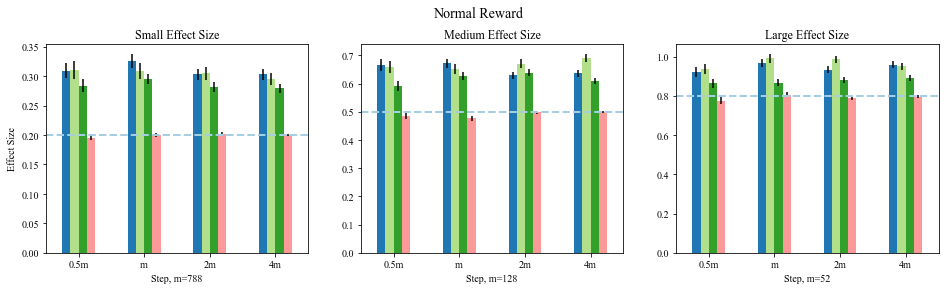

In [87]:
figure = plt.figure(figsize = (16, 4))
setLegend = False
stdError = True

# Plot subgraphs
for i in range(len(effectSizeN)):
    ax = figure.add_subplot(1, len(effectSizeN), i + 1)
    if i == 0:
        ax.set_ylabel("Effect Size")
    avg_act_es_normal = get_avg_col_per_num_steps_dfs(effectSizeN[i], "N", "actual_es", stdError=stdError)
    subplot_avg(avg_act_es_normal, effectSizeN[i], ax, setLegend, effectSize_label[i]+" Effect Size", \
                ylabel="Effect Size", hline_value=effectSizeN[i], hline_label="Expected Effect Size", setErrorBar=True)
    setLegend = False
    
# Set super title for all subgraphs
figure.suptitle("Normal Reward",  fontsize=14)
plt.subplots_adjust(top=0.85)

if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
    
figure.savefig(outdir+date_prefix+'AvgMeasuredESNormal.pdf', bbox_inches='tight')